# **Unsupervised Learning (Use Case 3)**
This notebook performs unsupervised learning techniques on the `insurance.csv` dataset.

We will execute two main tasks as per the project requirements:
1.  **Implement the clustering models** (K-Means, DBSCAN, HAC) for grouping policyholders based on demographic and health attributes (age, bmi, children).
2.  **Principal Component Analysis (PCA).**

## Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage as sci_linkage, dendrogram

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
pd.set_option("display.max_columns", 80)
sns.set_style("whitegrid")


## Helper Functions: Evaluation & Visualization

In [2]:
# Calculate clustering evaluation metrics
def evaluate_clustering(X, labels, model_name="model"):
    uniq = np.unique(labels)
    if -1 in uniq:
        n_clusters = len(uniq[uniq != -1])
    else:
        n_clusters = len(uniq)
    
    res = {
        'model': model_name,
        'n_clusters': n_clusters,
        'silhouette': None,
        'davies_bouldin': None,
        'calinski_harabasz': None,
    }
    
    if n_clusters >= 2:
        res['silhouette'] = silhouette_score(X, labels)
        res['davies_bouldin'] = davies_bouldin_score(X, labels)
        res['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    
    return res

# Plot 2D scatter of clusters
def plot_cluster_2d(X, labels, title="2D clusters"):
    plt.figure(figsize=(6, 5))
    for lab in np.unique(labels):
        m = labels == lab
        plt.scatter(X[m, 0], X[m, 1], s=30, alpha=0.7, label=f"Cluster {lab}")
    plt.title(title)
    plt.xlabel("Feature 1 (age scaled)")
    plt.ylabel("Feature 2 (bmi scaled)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot 3D scatter of clusters
def plot_cluster_3d(X, labels, title="3D clusters (age, bmi, children)"):
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    for lab in np.unique(labels):
        m = labels == lab
        ax.scatter(X[m, 0], X[m, 1], X[m, 2], s=30, alpha=0.7, label=f"Cluster {lab}")
    ax.set_xlabel("age (scaled)")
    ax.set_ylabel("bmi (scaled)")
    ax.set_zlabel("children (scaled)")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()


## Data Loading

### 2.1. Load Dataset
Load the `insurance_cleaned.csv` file.

In [3]:
df = pd.read_csv(r'C:\MyData\Workspace\mini_capstone\data\insurance_cleaned.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1337, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2.2. Define Preprocessing Pipeline
Machine learning algorithms, especially those sensitive to distance (like PCA and clustering), require numeric, standardized input.

We will define a `ColumnTransformer` to 
**StandardScaler**: Standardize numerical columns (mean=0, std=1).

In [4]:
# Features for clustering
features = ['age', 'bmi', 'children']
X_raw = df[features].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

## Clustering Model Evaluation Metrics

Before we run the clustering models, it's important to understand how we will evaluate them. Since this is unsupervised learning, we don't have "ground truth" labels. Instead, we use metrics that measure the quality of the clusters themselves based on their cohesion (density) and separation.

We will use these three metrics to find the optimal 'K' (number of clusters).

### 1. Silhouette Score

**Overview:**
The Silhouette Score measures how similar a data point is to its own cluster (cohesion) compared to how different it is from other clusters (separation).

**Formulation:**
For a single data point $i$:
* $a(i)$: The average distance from $i$ to all other points *in the same cluster*. (Measures cohesion)
* $b(i)$: The average distance from $i$ to all points in the *nearest neighboring cluster*. (Measures separation)

The Silhouette score $s(i)$ for that single point is:
$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$
The overall Silhouette Score is the average $s(i)$ for all points in the dataset.

**Interpretation:**
* **Range:** -1 to +1.
* **Goal: Maximize** the score.

### 2. Davies-Bouldin (DB) Index

**Overview:**
The DB Index measures the average "similarity" between each cluster and its *most similar* neighbor. "Similarity" is defined as the ratio of the clusters' internal spread (cohesion) to the distance between them (separation).

**Formulation:**
* $s_i$: The average distance from each point in cluster $i$ to its centroid (measures cohesion).
* $d_{ij}$: The distance between the centroids of cluster $i$ and cluster $j$ (measures separation).
* The similarity between two clusters $i$ and $j$ is: $R_{ij} = \frac{s_i + s_j}{d_{ij}}$
* The DB Index is the average of the *worst-case* similarity for each cluster:
    $$
    DB = \frac{1}{k} \sum_{i=1}^k \max_{i \neq j} (R_{ij})
    $$

**Interpretation:**
* **Range:** 0 to $+\infty$.
* **Goal: Minimize** the score. A lower score means clusters are compact and well-separated.

### 3. Calinski-Harabasz (CH) Index (Variance Ratio Criterion)

**Overview:**
The CH Index (also known as the Variance Ratio Criterion) measures the ratio of the variance *between* clusters to the variance *within* clusters.

**Formulation:**
* $SS_B$: The sum of squares *between* clusters (measures total separation).
* $SS_W$: The sum of squares *within* clusters (measures total cohesion/density).
* $k$: Number of clusters.
* $n$: Total number of data points.

The CH score is calculated as:
$$
CH = \frac{SS_B / (k-1)}{SS_W / (n-k)}
$$

**Interpretation:**
* **Range:** 0 to $+\infty$.
* **Goal: Maximize** the score.

## K-MEANS CLUSTERING

### 1. Overview

**K-Means** is an unsupervised clustering algorithm that aims to partition a dataset into $k$ clusters so that data points within the same cluster are as similar as possible, while points in different clusters are as dissimilar as possible. Each cluster is represented by its centroid (mean position of all the points in the cluster).

### 2. Working Principle

K-Means minimizes the within-cluster sum of squared distances (WCSS) between data points and their respective cluster centroids.

### 3. Mathematical Formulation

Given a dataset $X = \{x_1, x_2, ..., x_n\}$ in $\mathbb{R}^d$ and number of clusters $k$, the objective is to:

$$
\underset{S}{\text{minimize}} \sum_{i=1}^k \sum_{x \in S_i} \| x - \mu_i \|^2
$$

- $S = \{S_1, S_2, ..., S_k\}$ is a partition of $X$
- $\mu_i$ is the centroid of cluster $S_i$: 

$$
\mu_i = \frac{1}{|S_i|} \sum_{x \in S_i} x
$$

### 4. Algorithm Steps

1. Randomly initialize $k$ cluster centroids.
2. Assign each data point to the nearest centroid.
3. Update centroids as the mean of points assigned to each cluster.
4. Repeat steps 2–3 until assignments do not change (convergence).

### 5. Advantages and Disadvantages

**Advantages:**
- Simple and fast for large datasets.
- Efficient when clusters are roughly convex and isotropic.

**Disadvantages:**
- Need to specify $k$ in advance.
- Sensitive to initial centroid placement.
- Performs poorly with clusters of varying size/density or non-globular shapes.


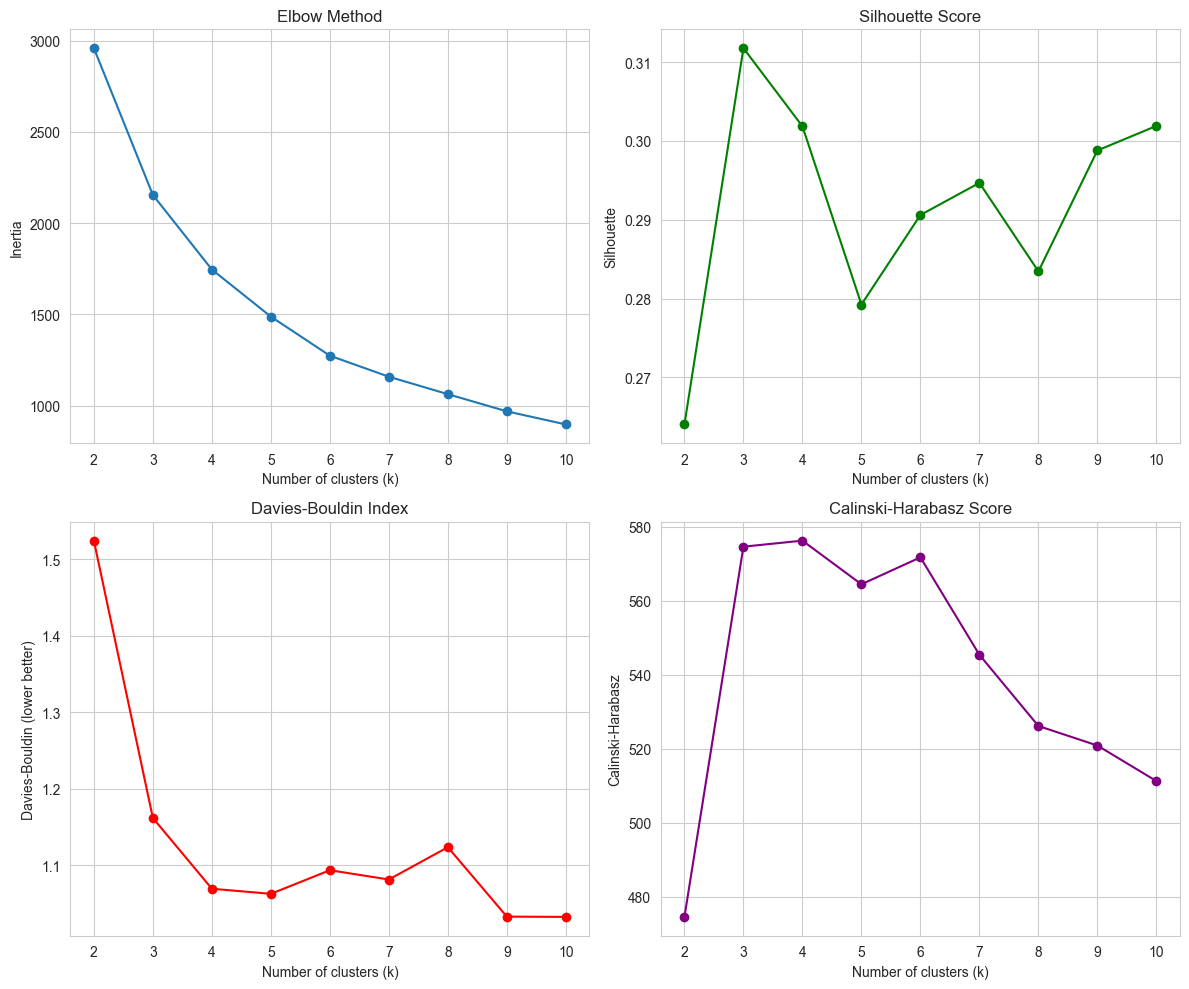

In [5]:
#elbow method for k-means
k_range = range(2, 11)
kmeans_search = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    kmeans_search.append({
        'k': k,
        'Inertia': kmeans.inertia_,
        'Silhouette': silhouette_score(X_scaled, labels),
        'Davies-Bouldin': davies_bouldin_score(X_scaled, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X_scaled, labels)
    })

kmeans_df = pd.DataFrame(kmeans_search)

# Plot elbow curve
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(kmeans_df['k'], kmeans_df['Inertia'], marker='o')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].set_xlabel('Number of clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(True)

axes[0, 1].plot(kmeans_df['k'], kmeans_df['Silhouette'], marker='o', color='green')
axes[0, 1].set_title('Silhouette Score')
axes[0, 1].set_xlabel('Number of clusters (k)')
axes[0, 1].set_ylabel('Silhouette')
axes[0, 1].grid(True)

axes[1, 0].plot(kmeans_df['k'], kmeans_df['Davies-Bouldin'], marker='o', color='red')
axes[1, 0].set_title('Davies-Bouldin Index')
axes[1, 0].set_xlabel('Number of clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin (lower better)')
axes[1, 0].grid(True)

axes[1, 1].plot(kmeans_df['k'], kmeans_df['Calinski-Harabasz'], marker='o', color='purple')
axes[1, 1].set_title('Calinski-Harabasz Score')
axes[1, 1].set_xlabel('Number of clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

K-MEANS (k=3)


,Metric,Value
0,Silhouette,0.311772
1,Davies-Bouldin,1.161974
2,Calinski-Harabasz,574.569015


,Cluster,Size,Percentage
0,0,399,29.842932
1,1,485,36.275243
2,2,453,33.881825



Coefficient of Variation: 0.0796


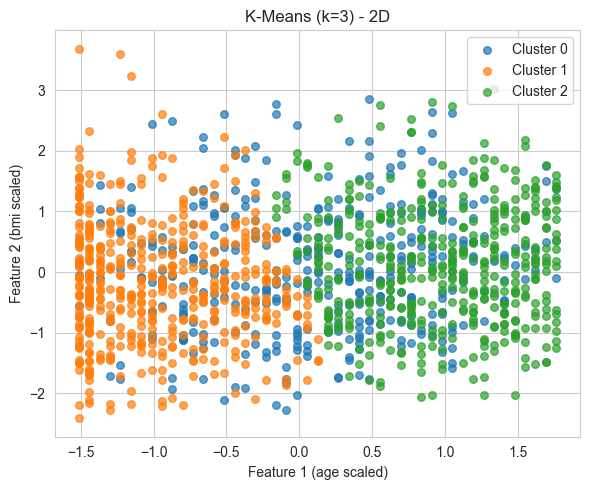

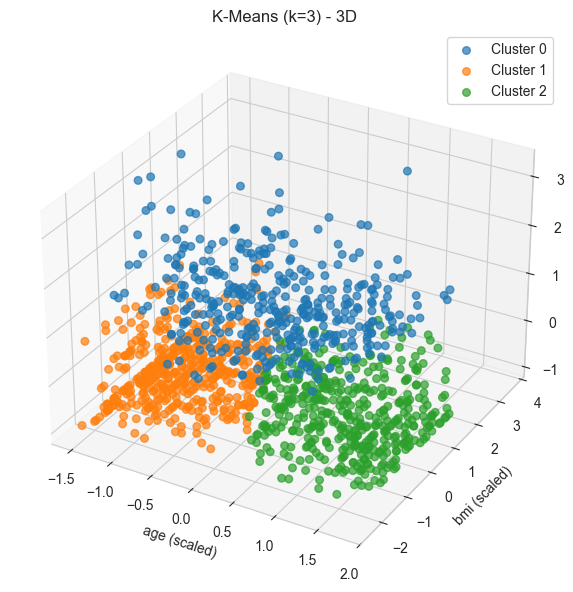

CLUSTER PROFILES:


age                             bmi                        \
              mean median min max count       mean median     min    max   
Cluster                                                                    
0        40.614035   41.0  18  64   399  31.089110  30.80  16.815  48.07   
1        25.529897   24.0  18  41   485  29.573732  29.15  15.960  53.13   
2        52.655629   53.0  37  64   453  31.455232  31.35  18.050  49.06   

               children                       
        count      mean median min max count  
Cluster                                       
0         399  2.654135    3.0   2   5   399  
1         485  0.443299    0.0   0   2   485  
2         453  0.421634    0.0   0   2   453

In [6]:
optimal_k = 3

# Fit final K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

print(f"K-MEANS (k={optimal_k})")

kmeans_metrics = pd.DataFrame([{
    'Metric': 'Silhouette',
    'Value': silhouette_score(X_scaled, kmeans_labels)
}, {
    'Metric': 'Davies-Bouldin',
    'Value': davies_bouldin_score(X_scaled, kmeans_labels)
}, {
    'Metric': 'Calinski-Harabasz',
    'Value': calinski_harabasz_score(X_scaled, kmeans_labels)
}])

display(kmeans_metrics)

# Cluster sizes
cluster_sizes = np.bincount(kmeans_labels)
size_df = pd.DataFrame({
    'Cluster': range(optimal_k),
    'Size': cluster_sizes,
    'Percentage': cluster_sizes / len(X_scaled) * 100
})

display(size_df)

cv = np.std(cluster_sizes) / np.mean(cluster_sizes)
print(f"\nCoefficient of Variation: {cv:.4f}")

# Visualizations
plot_cluster_2d(X_scaled, kmeans_labels, f"K-Means (k={optimal_k}) - 2D")
plot_cluster_3d(X_scaled, kmeans_labels, f"K-Means (k={optimal_k}) - 3D")

# Cluster profiles
df_kmeans = df.copy()
df_kmeans['Cluster'] = kmeans_labels

kmeans_profile = df_kmeans.groupby('Cluster')[features].agg(['mean', 'median', 'min', 'max', 'count'])

print("CLUSTER PROFILES:")
display(kmeans_profile)
print()

## DBSCAN - PARAMETER SELECTION

### 1. Overview

**DBSCAN** is a density-based clustering algorithm that discovers clusters of arbitrary shape and automatically detects noise (outliers). Proposed by Martin Ester et al. (1996), it is widely used in computer vision, data analysis, and pattern recognition.

### 2. Key Concepts
- **Epsilon ($\epsilon$):** The radius parameter to define a point's neighborhood.
- **MinPts:** The minimum number of points required to form a dense region.
- **Core point:** A point with at least MinPts (including itself) within its $\epsilon$-neighborhood.
- **Border point:** Not a core point, but within the $\epsilon$-neighborhood of a core point.
- **Noise point (outlier):** Neither a core point nor within the $\epsilon$-neighborhood of any core point.

### 3. Mathematical Formulation

- The $\epsilon$-neighborhood of point $x_i$:
  $$
  N_\epsilon(x_i) = \{x_j \in D \mid \|x_j - x_i\| \leq \epsilon\}
  $$
  where $D$ is the data set, $\|\cdot\|$ denotes the Euclidean norm.

- **Core point** condition:
  $$
  |N_\epsilon(x_i)| \geq \text{MinPts}
  $$

- Two points are **density-connected** if there is a chain of core points linking them, each within distance $\epsilon$ of the next.

### 4. Pseudo-Algorithm

1. Select an unvisited point.
2. If it is a core point, create a new cluster and recursively add all density-connected points to it.
3. Repeat until all points are considered.
4. Points that do not belong to any cluster are labeled noise.

### 5. Advantages and Disadvantages

**Advantages:**
- No need to specify the number of clusters in advance.
- Handles clusters of arbitrary shape well.
- Detects outliers effectively.

**Disadvantages:**
- Sensitive to the choice of $\epsilon$ and MinPts.
- Performs poorly with large variations in density.


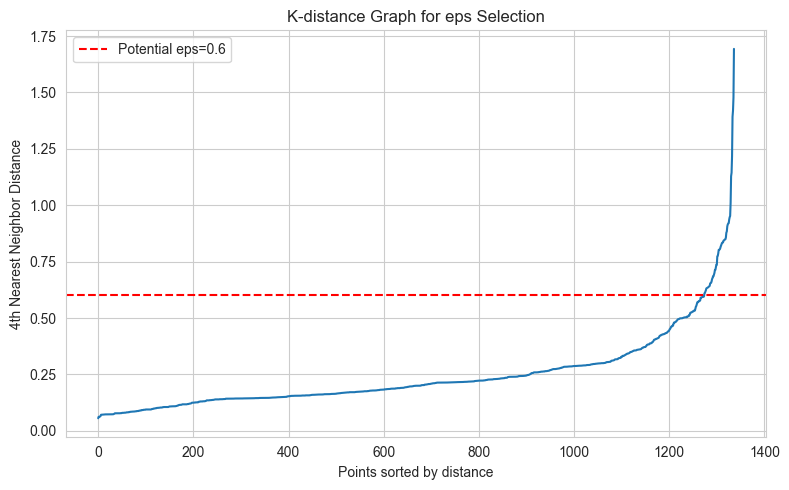

,eps,n_clusters,n_noise,silhouette,davies_bouldin,calinski_harabasz
0,0.3,8,187,-0.071260,1.699056,78.574936
1,0.4,9,99,0.036610,1.673490,79.627887
2,0.5,8,57,0.042403,1.860692,89.965919
3,0.6,7,40,0.051477,2.086536,101.320868
4,0.7,6,23,0.086494,2.468377,120.575292
5,0.8,6,17,0.086720,2.575165,125.712261


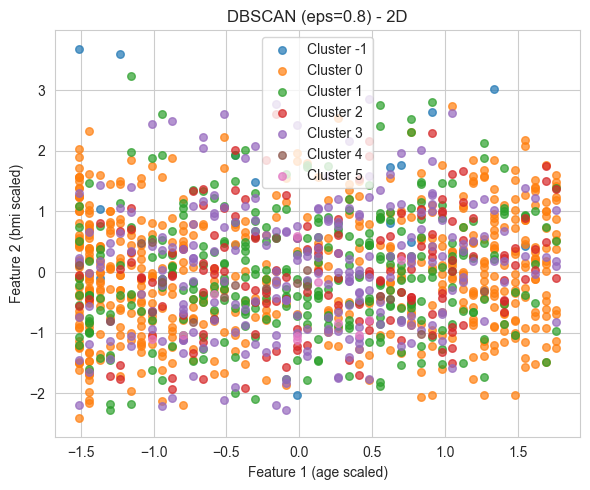

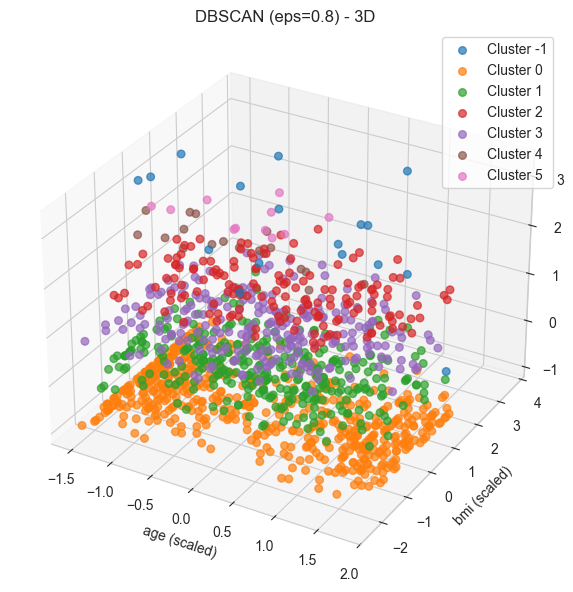

In [7]:
# Compute k-distance graph
min_pts = 5
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
k_distances = np.sort(distances[:, min_pts-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_pts-1}th Nearest Neighbor Distance')
plt.title('K-distance Graph for eps Selection')
plt.axhline(y=0.6, color='r', linestyle='--', label='Potential eps=0.6')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# DBSCAN parameter sweep
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    mask = labels != -1
    if sum(mask) > 0 and len(set(labels[mask])) > 1:
        sil = silhouette_score(X_scaled[mask], labels[mask])
        db = davies_bouldin_score(X_scaled[mask], labels[mask])
        ch = calinski_harabasz_score(X_scaled[mask], labels[mask])
    else:
        sil = db = ch = np.nan
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'labels': labels
    })

dbscan_df = pd.DataFrame(dbscan_results).drop('labels', axis=1)
display(dbscan_df)

# Select best DBSCAN
valid_results = [r for r in dbscan_results if not np.isnan(r['silhouette'])]
best_dbscan = max(valid_results, key=lambda x: x['silhouette'])

# Get best DBSCAN labels
dbscan_labels = best_dbscan['labels']

# Visualizations
plot_cluster_2d(X_scaled, dbscan_labels, f"DBSCAN (eps={best_dbscan['eps']}) - 2D")
plot_cluster_3d(X_scaled, dbscan_labels, f"DBSCAN (eps={best_dbscan['eps']}) - 3D")



## HAC - HIERARCHICAL AGGLOMERATIVE CLUSTERING

### 1. Overview

**HAC (Hierarchical Agglomerative Clustering)** is a "bottom-up" clustering algorithm. It starts by treating each point as a cluster, then iteratively **merges the two closest clusters** until only one remains. The result is visualized using a **Dendrogram**.

### 2. Key Concepts
- **Dendrogram:** A tree diagram showing the merge hierarchy. "Cutting" the tree at a specific height yields a set number of clusters.
- **Linkage Criteria:** The method used to measure the distance between two clusters (e.g., Single, Complete, Average). This is the key parameter.
- **Agglomerative:** The "bottom-up" merging strategy.

### 3. Mathematical Formulation (Linkage Criteria)

- **Single Linkage:** (Minimum distance)
  $$
  D(C_i, C_j) = \min_{x \in C_i, y \in C_j} \|x - y\|
  $$

- **Complete Linkage:** (Maximum distance)
  $$
  D(C_i, C_j) = \max_{x \in C_i, y \in C_j} \|x - y\|
  $$

- **Average Linkage:** (Average distance)
  $$
  D(C_i, C_j) = \frac{1}{|C_i| |C_j|} \sum_{x \in C_i} \sum_{y \in C_j} \|x - y\|
  $$

- **Ward's Method:** Minimizes the increase in total within-cluster variance after merging.

### 4. Pseudo-Algorithm

1.  **Initialize:** Each point is its own cluster.
2.  Compute the distance matrix between all clusters.
3.  **Repeat (until 1 cluster remains):**
    a. Find the two closest clusters, $C_i, C_j$ (based on **Linkage Criterion**).
    b. Merge $C_i$ and $C_j$ into a new cluster.
    c. Update the distance matrix.
4.  The final result is the complete dendrogram.

### 5. Advantages and Disadvantages

**Advantages:**
- No need to pre-specify the number of clusters (K).
- The resulting dendrogram is highly intuitive and interpretable.
- Can handle non-convex shapes (with Single Linkage).

**Disadvantages:**
- High computational complexity (often $O(n^3)$), unsuitable for large datasets.
- Very sensitive to the choice of linkage criterion.
- Merge decisions are irreversible (a greedy approach).

,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,"HAC(ward, k=2)",2,0.237493,1.676578,401.722589
1,"HAC(ward, k=3)",3,0.237653,1.331539,382.446655
2,"HAC(ward, k=4)",4,0.241191,1.241036,417.283947
3,"HAC(ward, k=5)",5,0.245048,1.195862,404.365105
4,"HAC(ward, k=6)",6,0.225760,1.206124,418.022832
5,"HAC(ward, k=7)",7,0.243878,1.192457,413.303160
6,"HAC(complete, k=2)",2,0.208613,1.678782,280.927946
7,"HAC(complete, k=3)",3,0.239345,1.420759,406.165089
8,"HAC(complete, k=4)",4,0.214374,1.299599,292.134022
9,"HAC(complete, k=5)",5,0.230453,1.148628,380.760219


Filtering criteria:
  • max_min_ratio < 10
  • min_cluster_size ≥ 20

Excluded 16 imbalanced configurations:


,model,max_min_ratio,min_size
8,"HAC(complete, k=4)",57.916667,12
9,"HAC(complete, k=5)",29.916667,12
10,"HAC(complete, k=6)",29.916667,12
11,"HAC(complete, k=7)",29.916667,12
12,"HAC(average, k=2)",444.666667,3
13,"HAC(average, k=3)",432.000000,3
14,"HAC(average, k=4)",291.333333,3
15,"HAC(average, k=5)",291.333333,3
16,"HAC(average, k=6)",159.333333,3
17,"HAC(average, k=7)",159.333333,3



Kept 8/24 balanced configurations

BEST HAC CONFIGURATION:


,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz,cv,max_min_ratio
4,"HAC(ward, k=6)",6,0.22576,1.206124,418.022832,0.385673,3.008197


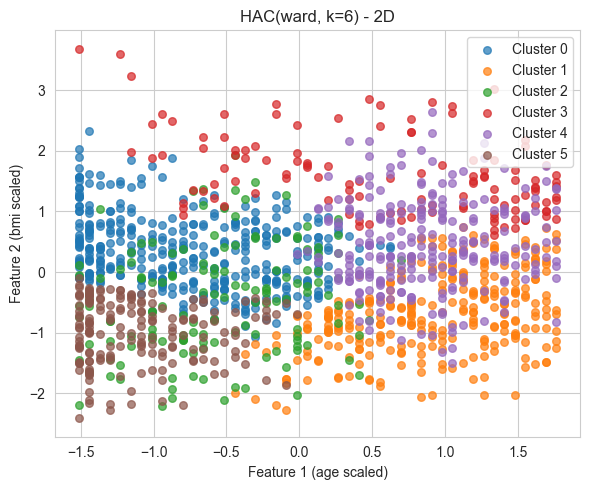

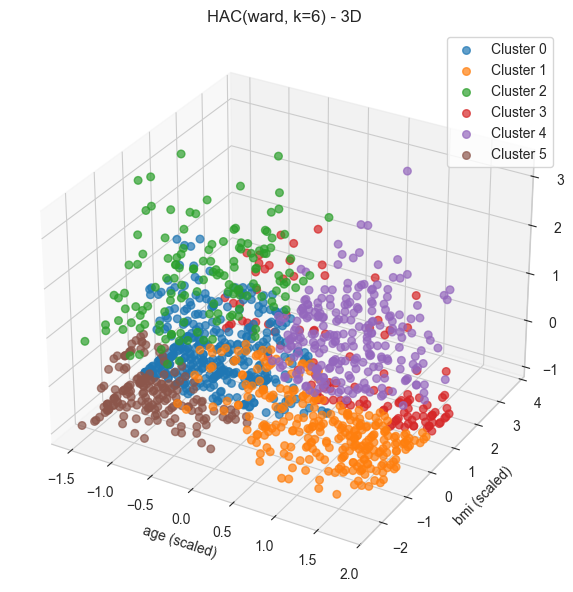

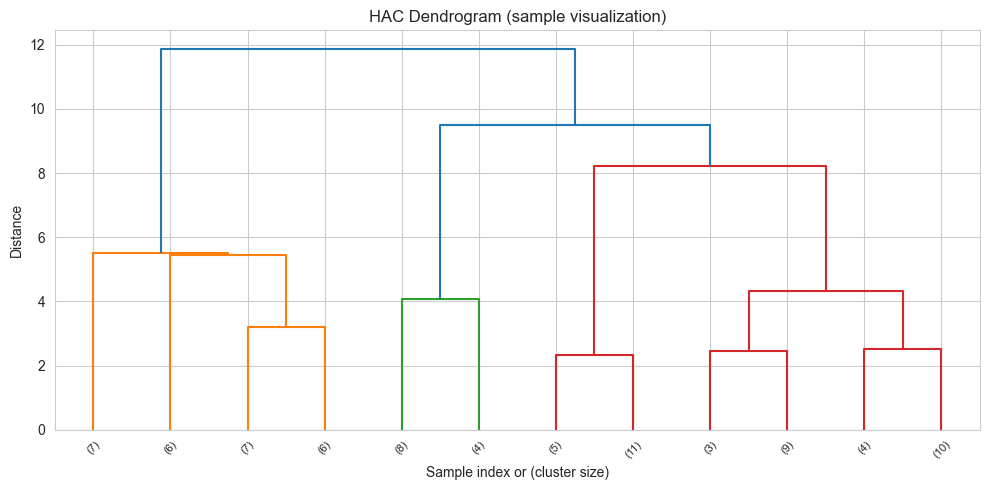

In [8]:
# Linkage methods comparison
linkages = ['ward', 'complete', 'average', 'single']
k_range_hac = range(2, 8)

hac_results = []

for link in linkages:
    for k in k_range_hac:
        if link == 'ward':
            model = AgglomerativeClustering(n_clusters=k, linkage=link)
        else:
            model = AgglomerativeClustering(n_clusters=k, linkage=link, metric='euclidean')
        
        labels = model.fit_predict(X_scaled)
        
        res = evaluate_clustering(X_scaled, labels, f"HAC({link}, k={k})")
        hac_results.append(res)

hac_df = pd.DataFrame(hac_results)
display(hac_df)

# Calculate balance metrics
balance_metrics = []
for _, row in hac_df.iterrows():
    # Get labels back from original results
    idx = hac_df.index.get_loc(_)
    
    # Recompute for balance
    link = row['model'].split('(')[1].split(',')[0]
    k = int(row['model'].split('k=')[1].split(')')[0])
    
    if link == 'ward':
        model = AgglomerativeClustering(n_clusters=k, linkage=link)
    else:
        model = AgglomerativeClustering(n_clusters=k, linkage=link, metric='euclidean')
    
    labels = model.fit_predict(X_scaled)
    sizes = np.bincount(labels)
    
    cv = np.std(sizes) / np.mean(sizes)
    max_min_ratio = max(sizes) / min(sizes)
    
    balance_metrics.append({
        'cv': cv,
        'max_min_ratio': max_min_ratio,
        'min_size': min(sizes)
    })

hac_df['cv'] = [m['cv'] for m in balance_metrics]
hac_df['max_min_ratio'] = [m['max_min_ratio'] for m in balance_metrics]
hac_df['min_size'] = [m['min_size'] for m in balance_metrics]

# Filter balanced configurations
RATIO_THRESHOLD = 10
MIN_SIZE_THRESHOLD = 20

hac_balanced = hac_df[
    (hac_df['max_min_ratio'] < RATIO_THRESHOLD) & 
    (hac_df['min_size'] >= MIN_SIZE_THRESHOLD)
].copy()

print(f"Filtering criteria:")
print(f"  • max_min_ratio < {RATIO_THRESHOLD}")
print(f"  • min_cluster_size ≥ {MIN_SIZE_THRESHOLD}")
print()

excluded = hac_df[
    (hac_df['max_min_ratio'] >= RATIO_THRESHOLD) | 
    (hac_df['min_size'] < MIN_SIZE_THRESHOLD)
]

if len(excluded) > 0:
    print(f"Excluded {len(excluded)} imbalanced configurations:")
    excluded_display = excluded[['model', 'max_min_ratio', 'min_size']]
    display(excluded_display)

print()
print(f"Kept {len(hac_balanced)}/{len(hac_df)} balanced configurations")
print()

# Select best by Calinski-Harabasz
best_hac = hac_balanced.sort_values(
    ['calinski_harabasz', 'silhouette'],
    ascending=[False, False]
).iloc[0]

print("BEST HAC CONFIGURATION:")
best_hac_display = best_hac[['model', 'n_clusters', 'silhouette', 'davies_bouldin', 
                              'calinski_harabasz', 'cv', 'max_min_ratio']].to_frame().T
display(best_hac_display)

# Recompute best HAC labels
link = best_hac['model'].split('(')[1].split(',')[0]
k = int(best_hac['model'].split('k=')[1].split(')')[0])

if link == 'ward':
    hac_final = AgglomerativeClustering(n_clusters=k, linkage=link)
else:
    hac_final = AgglomerativeClustering(n_clusters=k, linkage=link, metric='euclidean')

hac_labels = hac_final.fit_predict(X_scaled)

# Visualizations
plot_cluster_2d(X_scaled, hac_labels, f"HAC({link}, k={k}) - 2D")
plot_cluster_3d(X_scaled, hac_labels, f"HAC({link}, k={k}) - 3D")

# Dendrogram
sample_n = min(80, X_scaled.shape[0])
X_sample = X_scaled[:sample_n]

Z = sci_linkage(X_sample, method='ward', metric='euclidean')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=8.)
plt.title('HAC Dendrogram (sample visualization)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## COMPARATIVE ANALYSIS

In [9]:
# Comparison table
comparison_data = {
    'Algorithm': [
        'K-Means',
        'DBSCAN',
        f'HAC ({link})'
    ],
    'Optimal k': [
        optimal_k,
        best_dbscan['n_clusters'],
        k
    ],
    'Silhouette': [
        silhouette_score(X_scaled, kmeans_labels),
        best_dbscan['silhouette'],
        best_hac['silhouette']
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X_scaled, kmeans_labels),
        best_dbscan['davies_bouldin'],
        best_hac['davies_bouldin']
    ],
    'Calinski-Harabasz': [
        calinski_harabasz_score(X_scaled, kmeans_labels),
        best_dbscan['calinski_harabasz'],
        best_hac['calinski_harabasz']
    ]
}

comp_df = pd.DataFrame(comparison_data)
display(comp_df)



,Algorithm,Optimal k,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,K-Means,3,0.311772,1.161974,574.569015
1,DBSCAN,6,0.086720,2.575165,125.712261
2,HAC (ward),6,0.225760,1.206124,418.022832


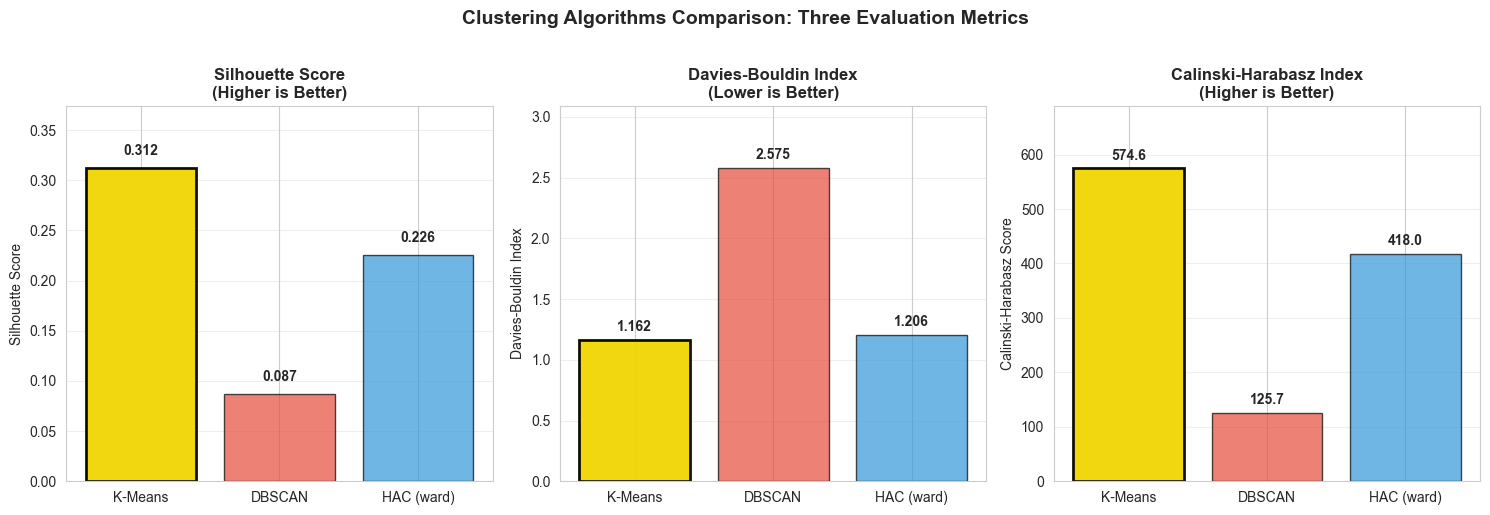

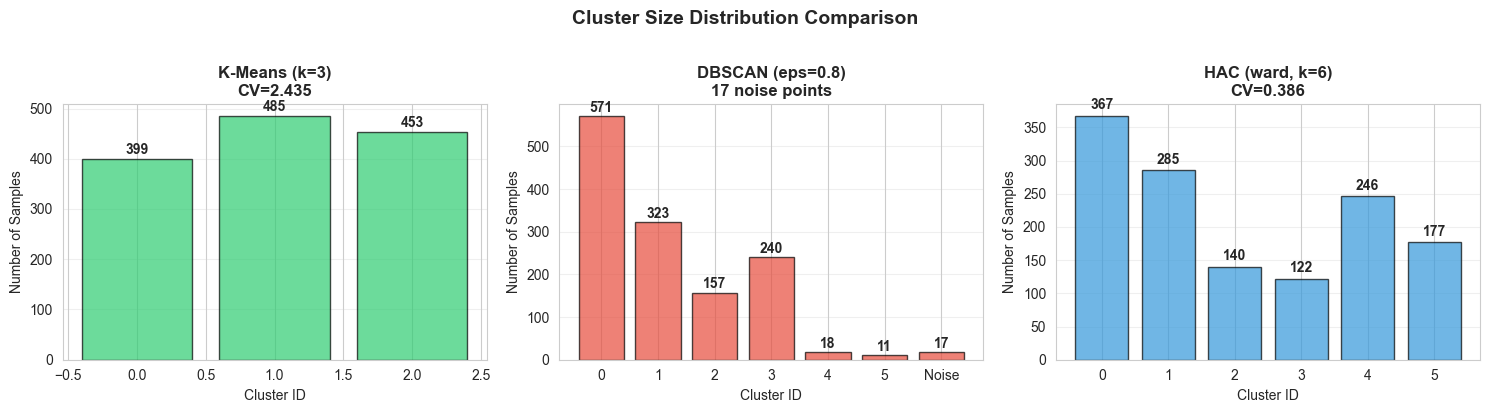

,Algorithm,CV (lower=better),Max/Min Ratio,Balance Assessment
0,K-Means,2.435,1.22:1,Excellent
1,DBSCAN,N/A (has noise),N/A,Unbalanced
2,HAC,0.386,3.01:1,Good


In [10]:
# Three panel bar chart comparing Silhouette, Davies-Bouldin, Calinski-Harabasz
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

algorithms = comp_df['Algorithm'].values
colors = ['#2ecc71', '#e74c3c', '#3498db']  # Green, Red, Blue

# Panel 1: Silhouette Score (higher is better)
axes[0].bar(algorithms, comp_df['Silhouette'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Silhouette Score\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_ylim(0, max(comp_df['Silhouette']) * 1.2)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (algo, val) in enumerate(zip(algorithms, comp_df['Silhouette'])):
    axes[0].text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight best
best_sil_idx = comp_df['Silhouette'].idxmax()
axes[0].bar(best_sil_idx, comp_df.loc[best_sil_idx, 'Silhouette'], 
            color='gold', alpha=0.9, edgecolor='black', linewidth=2)

# Panel 2: Davies-Bouldin Index (lower is better)
axes[1].bar(algorithms, comp_df['Davies-Bouldin'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_ylim(0, max(comp_df['Davies-Bouldin']) * 1.2)
axes[1].grid(axis='y', alpha=0.3)

for i, (algo, val) in enumerate(zip(algorithms, comp_df['Davies-Bouldin'])):
    axes[1].text(i, val + 0.05, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight best (lowest)
best_db_idx = comp_df['Davies-Bouldin'].idxmin()
axes[1].bar(best_db_idx, comp_df.loc[best_db_idx, 'Davies-Bouldin'], 
            color='gold', alpha=0.9, edgecolor='black', linewidth=2)

# Panel 3: Calinski-Harabasz Score (higher is better)
axes[2].bar(algorithms, comp_df['Calinski-Harabasz'], color=colors, alpha=0.7, edgecolor='black')
axes[2].set_title('Calinski-Harabasz Index\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_ylim(0, max(comp_df['Calinski-Harabasz']) * 1.2)
axes[2].grid(axis='y', alpha=0.3)

for i, (algo, val) in enumerate(zip(algorithms, comp_df['Calinski-Harabasz'])):
    axes[2].text(i, val + 10, f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# Highlight best
best_ch_idx = comp_df['Calinski-Harabasz'].idxmax()
axes[2].bar(best_ch_idx, comp_df.loc[best_ch_idx, 'Calinski-Harabasz'], 
            color='gold', alpha=0.9, edgecolor='black', linewidth=2)

plt.suptitle('Clustering Algorithms Comparison: Three Evaluation Metrics', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Cluster size distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# K-Means cluster sizes
kmeans_sizes = np.bincount(kmeans_labels)
axes[0].bar(range(len(kmeans_sizes)), kmeans_sizes, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0].set_title(f'K-Means (k={optimal_k})\nCV={cv:.3f}', fontweight='bold')
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', alpha=0.3)

for i, size in enumerate(kmeans_sizes):
    axes[0].text(i, size + 10, str(size), ha='center', fontweight='bold')

# DBSCAN cluster sizes
dbscan_sizes = []
for i in range(best_dbscan['n_clusters']):
    dbscan_sizes.append(np.sum(dbscan_labels == i))
if best_dbscan['n_noise'] > 0:
    dbscan_sizes.append(best_dbscan['n_noise'])
    labels_plot = list(range(best_dbscan['n_clusters'])) + ['Noise']
else:
    labels_plot = range(best_dbscan['n_clusters'])

axes[1].bar(range(len(dbscan_sizes)), dbscan_sizes, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1].set_title(f'DBSCAN (eps={best_dbscan["eps"]})\n{best_dbscan["n_noise"]} noise points', 
                  fontweight='bold')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xticks(range(len(labels_plot)))
axes[1].set_xticklabels(labels_plot)
axes[1].grid(axis='y', alpha=0.3)

for i, size in enumerate(dbscan_sizes):
    axes[1].text(i, size + 10, str(size), ha='center', fontweight='bold')

# HAC cluster sizes
hac_sizes = np.bincount(hac_labels)
axes[2].bar(range(len(hac_sizes)), hac_sizes, color='#3498db', alpha=0.7, edgecolor='black')
axes[2].set_title(f'HAC ({link}, k={k})\nCV={best_hac["cv"]:.3f}', fontweight='bold')
axes[2].set_xlabel('Cluster ID')
axes[2].set_ylabel('Number of Samples')
axes[2].grid(axis='y', alpha=0.3)

for i, size in enumerate(hac_sizes):
    axes[2].text(i, size + 10, str(size), ha='center', fontweight='bold')

plt.suptitle('Cluster Size Distribution Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Create balance comparison table
balance_comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN', 'HAC'],
    'CV (lower=better)': [f'{cv:.3f}', 'N/A (has noise)', f'{best_hac["cv"]:.3f}'],
    'Max/Min Ratio': [
        f'{max(kmeans_sizes)/min(kmeans_sizes):.2f}:1',
        'N/A',
        f'{best_hac["max_min_ratio"]:.2f}:1'
    ],
    'Balance Assessment': ['Excellent', 'Unbalanced', 'Good']
})

display(balance_comparison)

## BUSINESS INTERPRETATION

In [11]:
# Cluster profiles for K-Means
df_result = df.copy()
df_result['Cluster'] = kmeans_labels

cluster_names = {
    0: "Established Families",
    1: "Young Singles/Couples",
    2: "Senior Empty Nesters"
}

for cluster_id in range(optimal_k):
    cluster_data = df_result[df_result['Cluster'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}: {cluster_names[cluster_id]}")
    print(f"Size: {len(cluster_data)} ({len(cluster_data)/len(df)*100:.1f}%)")
    
    profile_df = pd.DataFrame({
        'Metric': ['Age', 'BMI', 'Children', 'Charges'],
        'Mean': [
            cluster_data['age'].mean(),
            cluster_data['bmi'].mean(),
            cluster_data['children'].mean(),
            cluster_data['charges'].mean()
        ]
    })
    
    display(profile_df)



CLUSTER 0: Established Families
Size: 399 (29.8%)


,Metric,Mean
0,Age,40.614035
1,BMI,31.089110
2,Children,2.654135
3,Charges,14731.184670



CLUSTER 1: Young Singles/Couples
Size: 485 (36.3%)


,Metric,Mean
0,Age,25.529897
1,BMI,29.573732
2,Children,0.443299
3,Charges,9337.794385



CLUSTER 2: Senior Empty Nesters
Size: 453 (33.9%)


,Metric,Mean
0,Age,52.655629
1,BMI,31.455232
2,Children,0.421634
3,Charges,16219.895072


## PCA - PRINCIPAL COMPONENT ANALYSIS

### 1. Overview

**PCA (Principal Component Analysis)** is an unsupervised technique used for **dimensionality reduction**. It transforms a set of correlated variables into a smaller set of uncorrelated variables called **Principal Components**, which capture the maximum possible variance from the original data.

### 2. Key Concepts
- **Principal Components (PCs):** A set of new, uncorrelated axes that capture the data's variance in descending order.
- **Covariance Matrix:** A matrix showing how variables change together. Its "directions" form the PCs.
- **Eigenvectors & Eigenvalues:** For the covariance matrix, eigenvectors define the *direction* of each PC, and eigenvalues define the *amount of variance* that PC captures.

### 3. Mathematical Formulation

1.  **Standardize** data $X$ (mean=0, std=1).
2.  **Compute Covariance Matrix ($\Sigma$):**
    $$
    \Sigma = \frac{1}{n-1} X^T X
    $$
3.  **Find Eigenpairs** (Eigenvalues $\lambda$, Eigenvectors $v$):
    $$
    \Sigma v = \lambda v
    $$
4.  **Select $k$ Components:** Choose the $k$ eigenvectors ($W$) corresponding to the $k$ largest eigenvalues.
5.  **Transform Data ($Y$):**
    $$
    Y = XW
    $$

Original features: 8
PCA components: 6
Variance retained: 94.53%

Top contributing features by |loading|:
PC1 → ['bmi', 'age', 'children', 'region_southeast', 'region_northwest']
PC2 → ['children', 'bmi', 'region_southeast', 'region_northwest', 'region_southwest']
PC3 → ['age', 'bmi', 'children', 'region_southeast', 'region_northwest']
PC4 → ['sex_male', 'region_southwest', 'region_southeast', 'smoker_yes', 'bmi']
PC5 → ['region_southwest', 'region_southeast', 'sex_male', 'region_northwest', 'bmi']
PC6 → ['region_northwest', 'region_southeast', 'region_southwest', 'sex_male', 'bmi']


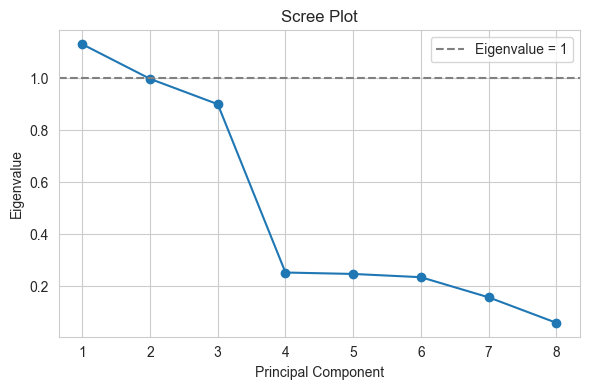

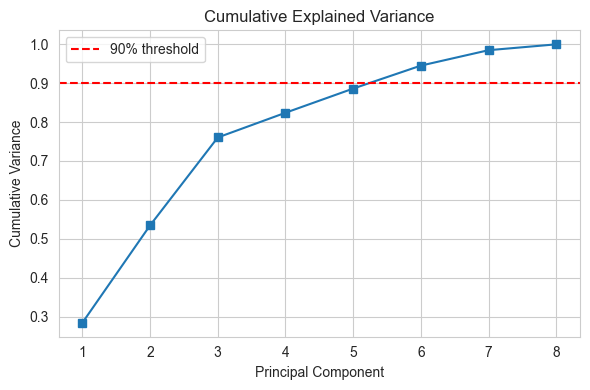

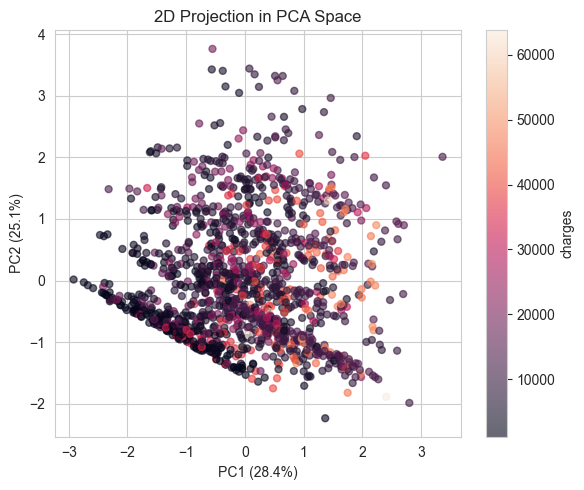


Reconstruction MSE: 0.027203  (lower = less info loss)


In [12]:
num = ["age", "bmi", "children"]
cat = ["sex", "smoker", "region"]
X = df[num + cat]

# Preprocessing: scale numeric features + One-Hot encode categorical features
ct = ColumnTransformer([
    ("num", StandardScaler(), num),
    ("cat", OneHotEncoder(drop="first", sparse_output=False,
                          handle_unknown="ignore"), cat)
])
Xz = ct.fit_transform(X)
feature_names = num + ct.named_transformers_["cat"].get_feature_names_out(cat).tolist()

# PCA: determine minimum k explaining ≥90% variance
pca_full = PCA().fit(Xz)
evr = pca_full.explained_variance_ratio_        # explained variance ratio
cum = evr.cumsum()                               # cumulative EVR
k = np.searchsorted(cum, 0.90) + 1               # choose k where cumulative ≥90%

# Fit PCA again with optimal number of components
pca = PCA(n_components=k).fit(Xz)
Z = pca.transform(Xz)

print(f"Original features: {len(feature_names)}")
print(f"PCA components: {k}")
print(f"Variance retained: {cum[k-1]*100:.2f}%")

# Feature contribution (loadings): identify key drivers per PC
loadings = pd.DataFrame(pca.components_.T, index=feature_names,
                        columns=[f"PC{i+1}" for i in range(k)])
print("\nTop contributing features by |loading|:")
for pc in loadings.columns:
    print(pc, "→", loadings[pc].abs().sort_values(ascending=False).head(5).index.tolist())

# Scree plot (eigenvalues)
plt.figure(figsize=(6,4))
plt.plot(range(1,len(evr)+1), pca_full.explained_variance_, marker="o")
plt.axhline(1.0, linestyle="--", color="gray", label="Eigenvalue = 1")
plt.title("Scree Plot")
plt.xlabel("Principal Component"); plt.ylabel("Eigenvalue")
plt.legend(); plt.tight_layout(); plt.show()

# Cumulative variance plot (elbow method)
plt.figure(figsize=(6,4))
plt.plot(range(1,len(cum)+1), cum, marker="s")
plt.axhline(0.90, linestyle="--", color="red", label="90% threshold")
plt.title("Cumulative Explained Variance")
plt.xlabel("Principal Component"); plt.ylabel("Cumulative Variance")
plt.legend(); plt.tight_layout(); plt.show()

# PC space visualization (PC1 vs PC2) — colored by charges (optional insight)
plt.figure(figsize=(6,5))
scatter = plt.scatter(Z[:,0], Z[:,1], c=df["charges"], alpha=0.6, s=25)
plt.colorbar(scatter, label="charges")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("2D Projection in PCA Space")
plt.tight_layout(); plt.show()

# Reconstruction error (information loss check)
X_rec = pca.inverse_transform(Z)
mse = np.mean((Xz - X_rec)**2)
print(f"\nReconstruction MSE: {mse:.6f}  (lower = less info loss)")
